## Begin creating algorithm to solve 2025 paper example by decomposition

In [1]:
# all imports

import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
#init_printing(use_unicode=True)
warnings.simplefilter('ignore')
import re
from sympy import *
import sympy
init_printing()




In [3]:


# Define our class:

class ModuleProperties:

    """ Class to define a reaction module, with methods to find hypergraphs, reaction cycles,
    
    Attributes:
        SM (Sympy Matrix): Stoichiometric Matrix of the reaction module
        num_internal_species (int): Number of internal species in the reaction module
        species_labels (dict): Labels for the species in the reaction module for hypergraph

    Methods:
        hypergraph_internals(): Generates and displays the hypergraph for internal species of the stoichiometric matrix
        hypergraph_full(): Generates and displays the hypergraph for the full stoichiometric matrix
        reaction_cycles_matrix(): Computes the reaction level cycles matrix for internal species
        coupling_matrix(): Computes the coupling matrix between internal and external species
        conservation_laws(): Computes the conservation law matrices for the full stoichiometric matrix and the chemostat species
        calculate_resistance_matrix(): Computes the reaction level resistance matrix for the module with sympy labelling of reactions
    """
    
    

    #==========================================================================================================================================
    # INIT
    #

    def __init__(self, SM, num_internal_species, hypergraph_labels, species_names):

        """ Initializes the ModuleProperties class with the full stoichiometric matrix, the internal and external stoichiometric matrices,
        and the labels of the species, reactions, forces, chemical potentials."""

        self.matrix = SM # Returns the passed SM, ready for print

        self.internal_SM = SM[0:num_internal_species, :] # finds the internal species SM by selecting the number of rows needed

        self.external_SM = SM[num_internal_species: len(SM), :] # finds SM for external species using remaning rows after internal species

        self.hypergraph_labels = hypergraph_labels # for the hypergraphs

        self.num_internal_species = num_internal_species

        
        # LABELLING FOR SPECIES, FORCES, EDGE CURRENTS, CHEMICAL POTENTIALS

        #self.species_labels = []

        self.chemical_potentials = []

        num_rows = self.matrix.rows
        

        for n in range(num_rows):
            
            #species_symbol = species_names[n]
            species_symbol = symbols(species_names[n])
            #self.species_labels.append(species_symbol)

            chem_pot = symbols(f"\mu_{species_symbol}")
            self.chemical_potentials.append(chem_pot)
            

        self.chemical_potentials_vector = Matrix(self.chemical_potentials).T  # make a vector out of the labelled chemical potentials
        
        # LABELS FOR ALL RESISTANCES AND REACTIONS

        num_cols = self.matrix.cols # Finds number of columns ( == no. of reactions) in the SM
       
        resistances = [] # define list to hold reaction labels
        edge_currents_j = [] # to hold the js
        forces = [] # to hold reaction level forces

        for n in range(num_cols): # loop over each reaction

            nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
            resistances.append(nth_resistance) # add to list of resistance

            nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth edge current
            edge_currents_j.append(nth_edge_currents_j) # add to list of currents

            reaction_vector = -1* self.matrix[:,n] # take the column of SM that corresponds to nth reaction
            
            forces.append(self.chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
        
        
        self.force_vector = Matrix(forces) # create a vector of reaction level forces
        self.edge_currents_vector = Matrix(edge_currents_j) # make a vector out of the js


        # reaction resistance in terms of r = f/j

        reaction_level_res = [] # to hold reaction level resistances

        for n in range(num_cols): # loop over each reaction

            symbolic_resistance = self.force_vector[n] / self.edge_currents_vector[n]

            reaction_level_res.append(symbolic_resistance)

        self.kinetic_form_resistance_matrix = Matrix.diag(reaction_level_res) # output reaction level res. matrix in terms of r = f/j
        
        
        
    #==========================================================================================================================================
    # HYPERGRAPHS
    #
    # Define a new function to find the hypergraphs for the internal species
    #

    def hypergraph_internals(self):

        """ This method generates and displays the hypergraph for the internal species of the module using the node
        labels defined in self.
        """

        internals_HG = hnx.Hypergraph.from_incidence_matrix(self.internal_SM) # create hypergraph, using the internal SM defined in self

        hnx.draw(internals_HG, node_labels=self.hypergraph_labels, with_edge_labels=True) # print this using the labels defined in self

    #
    # Define a new function to find the hypergraphs for the full stoichiometric matrix
    #

    def hypergraph_full(self):
        
        """ This method generates and displays the hypergraph for the full stoichiometric matrix of the module using the node
        labels defined in self.
        """

        full_HG = hnx.Hypergraph.from_incidence_matrix(self.matrix) # create hypergraph, using the full SM defined in self

        hnx.draw(full_HG, node_labels=self.hypergraph_labels, with_edge_labels=True) # print this using the labels defined in self

    #==========================================================================================================================================
    # REACTION LEVEL CYCLES
    #

    def calculate_reaction_cycles_matrix(self):

        """ This method calculates the reaction level cycles matrix for the internal species of the module using the 
        kernel of the internal stoichiometric matrix.
        
        Returns:
            cycle_matrix (Sympy Matrix): Reaction level cycles matrix for internal species
        """
        
        reaction_cycles = (self.internal_SM).nullspace() # finds the kernel for the SM internal

        # Check if there are any cycles:

        if not reaction_cycles:

            print("No internal cycles. Kernel is empty.")

        # build cycle matrix from kernel vectors if kernel is NOT empty

        else:

            cycle_matrix = reaction_cycles[0] # add first vector to cycle matrix so we can add rest later

            for cycle in reaction_cycles[1:]: # starting at second vector in kernel

                cycle_matrix = cycle_matrix.row_join(cycle) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together


            self.cycle_matrix = cycle_matrix # assign cycle matrix to self for use in other methods
            
            return cycle_matrix # return the cycle matrix
        
    #==========================================================================================================================================
    # COUPLING MATRICES
    #  

    def calculate_coupling_matrix(self):

        """ This method calculates the coupling matrix between internal and external species using reaction cycle matrix 
        and SM of external species.

        Returns:
            phi (Sympy Matrix): Coupling matrix between internal and external species
        """

        phi = self.external_SM * self.calculate_reaction_cycles_matrix()

        self.phi = phi
        return phi


    #==========================================================================================================================================
    # CONSERVATION LAW MATRICES
    #
    def calculate_conservation_laws(self):

        """ This method calculates the conservation law matrices for the full stoichiometric matrix and the chemostat species only.
        
        Returns:
            cons_laws.T (Sympy Matrix): Conservation law matrix for the full stoichiometric matrix  
            chemostat_laws.T (Sympy Matrix): Conservation law matrix for the chemostat species only
        """

        cokernel_SM = (self.matrix.T).nullspace() # finds the cokernel of the full SM

        if not cokernel_SM:

            print("No conservation laws. Cokernel of Stoichiometric Matrix empty.")

        else:

            cons_laws = cokernel_SM[0] # adds first element of cokernel

            for vec in cokernel_SM[1:]: # add vectors from next row onwards

                cons_laws = cons_laws.row_join(vec)


        #
        # Broken external laws for chemostat , deriving from the coupling matrix
        #

        coupling_matrix = self.calculate_coupling_matrix() # define the coupling matrix using the function defined previously

        cokernel_coupling_matrix = coupling_matrix.T.nullspace() # find the cokernel of the coupling matrix

        if not cokernel_coupling_matrix:

            print("No chemostat conservation laws. Cokernel of Coupling Matrix is empty.")

        # if cokernel is NOT empty

        else:

            chemostat_laws = cokernel_coupling_matrix[0] # add first vector to chemostat conservation law matrix so we can add rest later

            for law in cokernel_coupling_matrix[1:]: # starting at second vector in kernel

                chemostat_laws = chemostat_laws.row_join(law) # connect vectors from kernel column-wise, row_join puts elemetns of adjacent vectors together



        self.T_cons_laws = cons_laws.T # assign to self for use in other methods
        self.T_chemostat_laws = chemostat_laws.T # assign to self for use in other methods

        return cons_laws.T, chemostat_laws.T # return transpose to match equations in paper { L^(1) and l^(1) respectively}
    
    #==========================================================================================================================================
    # REACTION LEVEL RESISTANCE MATRIX
    #
    
    def calculate_reaction_resistance_matrix(self):

        """ Calculates the reaction level resistance matrix for the module, including an auto-labelling of reactions in the SM 
        according to the number of columns in the SM for use in Sympy operations."""
        
        

        num_cols = self.matrix.cols # Finds number of columns ( == no. of reactions) in the SM

        resistances = [] # define list to hold reaction labels
    
        for n in range(num_cols):

            nth_reaction = symbols(f"r{n+1}") # assign name of nth reaction

            resistances.append(nth_reaction) # add to list of reactions


    
        resistance_matrix = Matrix.diag(resistances) # create diagonal matrix from list of reactions

        self.resistance_matrix = resistance_matrix # assign to self for use in other methods

        return resistance_matrix
        
        
        
    #==========================================================================================================================================
    # CYCLE RESISTANCE MATRIX
    #

    def calculate_cycle_resistance_matrix(self):

        """ Uses the reaction level resistance matrix and reaction cycles matrix to calculate the cycle resistance matrix for the module.
        
        Returns:
            cycle_resistance_matrix (Sympy Matrix): Cycle resistance matrix for the module"""

        cycle_resistance_matrix = self.calculate_reaction_cycles_matrix().T * self.calculate_reaction_resistance_matrix() \
        * self.calculate_reaction_cycles_matrix()

        return cycle_resistance_matrix
    
    #==========================================================================================================================================
    # CONDUCATANCE MATRICES
    #

    def calculate_physical_conductance_matrix(self):

        physical_conductance_matrix = self.calculate_coupling_matrix() * self.calculate_cycle_resistance_matrix().inv() \
              * self.calculate_coupling_matrix().T        


        return physical_conductance_matrix


    #def caclulate_fundamental_conductance_matrix(self):

        #fundamental_conductance_matrix = self.calculate_conservation_laws()[0] * calculate_cycle_resistance_matrix().inv()

    #==========================================================================================================================================
    # REACTION CURRENTS
    #

    def calculate_physical_currents(self):

        currents_constraints = sympy.solve (self.internal_SM * self.edge_currents_vector, self.edge_currents_vector)

        currents = (-1* self.external_SM * self.edge_currents_vector).subs(currents_constraints)

        return currents
    
    def labels(self):
        return self.hypergraph_labels
    
class CombiningModules:
    
    def __init__(self, mod1, mod2):
        
        #==========================================================================================================================================
        # SOLVING FOR LEFT RIGHT SPLITTING OF CURRENTS
        #
    
        self.mod1 = mod1
        self.mod2 = mod2
        self.mod1_external_species_list = {i: v for i, v in enumerate(list(self.mod1.labels().values())[self.mod1.internal_SM.rows:])}
        self.mod2_external_species_list = {i: v for i, v in enumerate(list(self.mod2.labels().values())[self.mod2.internal_SM.rows:])}
        
        # FIND MATCHING SPECIES BETWEEN THE TWO MODULES
        self.matching_species = []
        for key1, value1 in self.mod1_external_species_list.items():
            for key2, value2 in self.mod2_external_species_list.items():
                if value1 == value2:
                    self.matching_species.append((key1, key2))

        if self.matching_species:
            self.keys_1, self.keys_2 = zip(*self.matching_species)
            self.keys_1 = list(self.keys_1)
            self.keys_2 = list(self.keys_2)
        else:
            self.keys_1, self.keys_2 = [], []
        # FOUND THEM

        # NOw SET UP THE LEFT RIGHT SPLITTING OF CURRENTS
        
        self.mod1_right_current = sympy.Matrix([self.mod1.calculate_physical_currents()[i] for i in self.keys_1])
        self.mod2_left_current = sympy.Matrix([self.mod2.calculate_physical_currents()[i] for i in self.keys_2])
        
        self.mod1_left_current = sympy.Matrix([self.mod1.calculate_physical_currents()[i] for i in range(self.mod1.external_SM.rows) if i not in self.keys_1])
        self.mod2_right_current = sympy.Matrix([self.mod2.calculate_physical_currents()[i] for i in range(self.mod2.external_SM.rows) if i not in self.keys_2])
        
        
        constraint_eqs = []
        for i in range(len(self.mod1_right_current)):
            constraint_eqs.append(self.mod1_right_current[i] + self.mod2_left_current[i])

        symbols_mod1 = self.mod1_right_current.free_symbols

        #SOLVING THE LINEAR EQUATIONS FOR THE CONSTRAINTS 
        # CHECK THIS FOR COMPLEXITY
        self.constraints = sympy.solve(constraint_eqs, symbols_mod1)

        # calculating the currents again with constraints applied
        self.mod1_current = self.mod1.calculate_physical_currents().subs(self.constraints)
        self.mod2_current = self.mod2.calculate_physical_currents().subs(self.constraints)

        # RELABELLING
        self.mod1_right_current = sympy.Matrix([self.mod1_current[i] for i in self.keys_1])
        self.mod2_left_current = sympy.Matrix([self.mod2_current[i] for i in self.keys_2])
        self.mod1_left_current = sympy.Matrix([self.mod1_current[i] for i in range(self.mod1.external_SM.rows) if i not in self.keys_1])
        self.mod2_right_current = sympy.Matrix([self.mod2_current[i] for i in range(self.mod2.external_SM.rows) if i not in self.keys_2])
        
        self.mod3_current = sympy.Matrix.vstack(self.mod1_left_current, self.mod2_right_current)

        #==========================================================================================================================================
        # LEFT RIGHT SPLITTING OF CONSERVATION LAWS
        #

        self.mod1_cons_laws_chemostat = sympy.Matrix([sympy.Matrix(self.mod1.calculate_coupling_matrix()).T.nullspace()]).T
        self.mod2_cons_laws_chemostat = sympy.Matrix([sympy.Matrix(self.mod2.calculate_coupling_matrix()).T.nullspace()]).T

        self.mod1_cons_laws_chemostat_left = self.mod1_cons_laws_chemostat[:, :len(self.mod1_left_current)]
        self.mod1_cons_laws_chemostat_right = self.mod1_cons_laws_chemostat[:, len(self.mod1_left_current):]

        self.mod2_cons_laws_chemostat_left = self.mod2_cons_laws_chemostat[:, :len(self.mod2_left_current)] 
        self.mod2_cons_laws_chemostat_right = self.mod2_cons_laws_chemostat[:, len(self.mod2_left_current):]    

        self.L_i = sympy.Matrix.vstack(-self.mod1_cons_laws_chemostat_right, self.mod2_cons_laws_chemostat_left)

        L_e = sympy.BlockMatrix([
        [self.mod1_cons_laws_chemostat_left, sympy.ZeroMatrix(self.mod1_cons_laws_chemostat_left.shape[0], self.mod2_cons_laws_chemostat_right.shape[1])],
        [sympy.ZeroMatrix(self.mod2_cons_laws_chemostat_right.shape[0], self.mod1_cons_laws_chemostat_left.shape[1]), self.mod2_cons_laws_chemostat_right]])
        self.L_e = sympy.Matrix(L_e)

        self.null_basis = (self.L_i.T).nullspace()
        if self.null_basis:
            self.v = sympy.Matrix.hstack(*self.null_basis).T
        else:
            self.v = sympy.Matrix([])

        self.mod3_cons_laws_chemostat = sympy.Matrix(self.v * self.L_e)

        #==========================================================================================================================================
        # CALCULATING THE SELECTION MATRICES
        #

        null_basis_1 = self.mod1_cons_laws_chemostat.nullspace()
        null_basis_2 = self.mod2_cons_laws_chemostat.nullspace()
        null_basis_3 = self.mod3_cons_laws_chemostat.nullspace()

        if null_basis_1:
            self.mod1_selection_matrix = sympy.Matrix.hstack(*null_basis_1)
        else:
            self.mod1_selection_matrix = sympy.Matrix([])

        if null_basis_2:
            self.mod2_selection_matrix = sympy.Matrix.hstack(*null_basis_2)
        else:
            self.mod2_selection_matrix = sympy.Matrix([])
        
        if null_basis_3:
            self.mod3_selection_matrix = sympy.Matrix.hstack(*null_basis_3)
        else:
            self.mod3_selection_matrix = sympy.Matrix([])

        #==========================================================================================================================================
        # CALCULATING PI MATRICIES
        #
        
        self.pi = sympy.Matrix(self.L_i.pinv() * self.L_e)

        self.pi_rows, self.pi_cols = self.pi.shape

        self.identity_part_1 = sympy.eye(len(self.mod1_left_current), self.pi_cols)
        self.pi_1_3 = self.identity_part_1.col_join(self.pi)

        self.identity_part_2 = sympy.eye(len(self.mod2_right_current), self.pi_cols-self.pi_rows)
        self.zeros_part_2 = sympy.zeros(len(self.mod2_right_current), self.pi_rows)
        self.bottom_part_2 = self.zeros_part_2.row_join(self.identity_part_2)
        self.pi_2_3 = (-self.pi).col_join(self.bottom_part_2)

        self.PI_1_3 = sympy.Matrix(self.mod1_selection_matrix.pinv() * self.pi_1_3 * self.mod3_selection_matrix)
        self.PI_2_3 = sympy.Matrix(self.mod2_selection_matrix.pinv() * self.pi_2_3 * self.mod3_selection_matrix)

        #==========================================================================================================================================
        # CALCULATING CONDUCTANCE MATRICES AND THIS SET OF FUNCTIONS WHICH RELABELS RESISTANCES
        #

        self.mod1_conductance_matrix = self.mod1_selection_matrix.pinv() * self.mod1.calculate_physical_conductance_matrix() * self.mod1_selection_matrix.T.pinv()
        self.mod2_conductance_matrix = self.mod2_selection_matrix.pinv() * self.mod2.calculate_physical_conductance_matrix() * self.mod2_selection_matrix.T.pinv()

        # FROM AI
        # REMAPPING THE SECOND MODULE CONDUCTANCE MATRIX RESISTANCES
        # 
        # The indices will look like r_1, r_2, r_3... r_n for module 1 
        #  and r_{n+1}, ... module 2  
        SUB_TO_DIGIT = {'₀':'0','₁':'1','₂':'2','₃':'3','₄':'4','₅':'5','₆':'6','₇':'7','₈':'8','₉':'9'}
        DIGIT_TO_SUB = {v:k for k,v in SUB_TO_DIGIT.items()}

        def parse_symbol_name(name):
            if '_' in name:
                prefix, idx = name.split('_', 1)
                if idx.isdigit():
                    return prefix, idx, 'underscore'
            i = len(name)-1
            while i >= 0 and name[i].isdigit():
                i -= 1
            if i < len(name)-1:
                return name[:i+1], name[i+1:], 'ascii'
            i = len(name)-1
            while i >= 0 and name[i] in SUB_TO_DIGIT:
                i -= 1
            if i < len(name)-1:
                prefix = name[:i+1]
                idx = ''.join(SUB_TO_DIGIT[ch] for ch in name[i+1:])
                return prefix, idx, 'unicode'
            return None, None, None

        def build_name(prefix, new_index, style):
            if style == 'underscore':
                return f"{prefix}_{new_index}"
            if style == 'unicode':
                return f"{prefix}{''.join(DIGIT_TO_SUB[d] for d in str(new_index))}"
            return f"{prefix}{new_index}"

        def shift_expr_variables(expr, shift):
            symbols = expr.atoms(sympy.Symbol)
            if not symbols:
                return expr
            subs = {}
            for s in symbols:
                prefix, idx_str, style = parse_symbol_name(s.name)
                if prefix is None:
                    continue
                new_idx = int(idx_str) + int(shift)
                new_name = build_name(prefix, new_idx, style)
                subs[s] = sympy.Symbol(new_name, **s.assumptions0)
            return expr.xreplace(subs)

        def shift_matrix_variables(matrix, shift):
            return matrix.applyfunc(lambda e: shift_expr_variables(e, shift))
        
        
        self.mod2_conductance_matrix = shift_matrix_variables(self.mod2_conductance_matrix, 3)

        #==========================================================================================================================================
        # THE DEFINING OF THE DEFINING EQUATION FOR THE COMBINED MODULE RESISTANCE MATRIX
        #

        self.mod3_resistance_matrix = self.PI_1_3.T * self.mod1_conductance_matrix.inv() * self.PI_1_3 + self.PI_2_3.T * self.mod2_conductance_matrix.inv() * self.PI_2_3

        


## Example from the 2025 paper - combining two modules by identifying shared species

In [7]:
# first module, defined from the stoichiometric matrix and some labels
SM_1 = Matrix( [[-1, 1, 0], [1, -1, -1], [0, 0, 1], [-1, 0, -1], [0, 1, 0]] ) # The SM of module 1

num_internal_species = 3 # for extracting the internal and external SMs

labels = {0: 'Ea', 1: 'EaS', 2: 'EaS2', 3: 'S', 4: 'Na'}
species_names1 = ["Ea", "EaS", "EaS2", "S", "Na"]

mod1 = ModuleProperties(SM_1, num_internal_species, labels, species_names1)
mod1.matrix.cols

In [10]:
# second module, defined from the stoichiometric matrix and some labels
stoich_matrix_2 = Matrix([[-1, 0, 1, 0, 0], # first row of internal
                           [1, -1, 0, -1, 0], 
                           [0, 1, -1, 0, 1], 
                           [0, 0, 0, 1, -1],
                             [0, 0, 0, -1, 0], # first row external 
                             [0, 0, 0, 0, 1],
                             [-1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0]])


labels_mod2 = {0: 'Eb', 1: 'EbF', 2: 'EbW', 3: 'Eb*', 4: 'Na', 5: 'Nb', 6: 'F', 7: 'W'}
species_names2 = ["Eb", "EbF", "EbW", "Eb*", "Na", "Nb", "F", "W"]


mod2 = ModuleProperties(stoich_matrix_2, 4,labels_mod2, species_names2)

# If we want, we can directly calculate the reaction resistance matrix
# mod2.calculate_reaction_resistance_matrix()


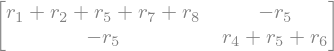

In [11]:
# constructing the total resistance matrix of module 1 and module 2 combined
CombiningModules(mod1, mod2).mod3_resistance_matrix


The rest is ignored.

In [252]:


# LABELS FOR ALL SPECIES AND CHEMICAL POTENTIALS

SM_1 = Matrix( [[-1, 1, 0], [1, -1, -1], [0, 0, 1], [-1, 0, -1], [0, 1, 0]] ) # The SM of module 1

species_names = ["Ea", "EaS", "EaS2", "S", "Na"] # species for module 1 in latex notation
species_labels = []

chemical_potentials = []

num_rows = 5 #self.matrix.rows

for n in range(num_rows):
    
    species_symbol = species_names[n]
    species_symbol = symbols(species_symbol)
    species_labels.append(species_symbol)

    chem_pot = symbols(f"\mu_{species_symbol}")
    chemical_potentials.append(chem_pot)
    

edge_currents_vector = Matrix([edge_currents_j]) # make a vector out of the js
chemical_potentials_vector = Matrix([chemical_potentials]) # make a vector out of the labelled chemical potentials




# LABELS FOR ALL RESISTANCES AND REACTIONS

num_cols = 3 #self.matrix.cols # Finds number of columns ( == no. of reactions) in the SM

resistances = [] # define list to hold reaction labels
edge_currents_j = []
forces = []

for n in range(num_cols):

    nth_resistance = symbols(f"r{n+1}") # assign name of nth resistance
    resistances.append(nth_resistance) # add to list of resistance

    nth_edge_currents_j = symbols(f"j{n+1}") # assign name of nth resistance
    edge_currents_j.append(nth_edge_currents_j) # add to list of resistance

    reaction_vector = -1* SM_1[:,n] #self.matrix[:,n]
    
    forces.append(chemical_potentials_vector*reaction_vector) # use reaction vector *-1  in SM to create forces in terms of chem potentials
    
force_vector = Matrix([forces]).T



# reaction resistance in terms of r = f/j

reaction_level_res = []

for n in range(num_cols):

    symbolic_resistance = force_vector[n] / edge_currents_vector[n]

    reaction_level_res.append(symbolic_resistance)

kinetic_form_resistance_matrix = Matrix([reaction_level_res])




NameError: name 'edge_currents_j' is not defined